In [1]:
import pandas as pd

In [22]:
df = pd.read_csv('train.csv')

In [26]:
df.dtypes

image_names         object
emergency_or_not     int64
dtype: object

In [5]:
df['name'] = pd.to_numeric(df['image_names'].str.replace('.jpg', '', regex=False))

In [8]:
df.sort_values(by='name')

,image_names,emergency_or_not,name
880,0.jpg,1,0
1489,1.jpg,1,1
164,2.jpg,1,2
669,3.jpg,1,3
1316,4.jpg,1,4
...,...,...,...
1289,2346.jpg,0,2346
753,2347.jpg,0,2347
869,2348.jpg,0,2348
349,2350.jpg,0,2350


In [9]:
df.to_csv('sub.csv',index=False)

In [10]:
df1 = pd.read_csv('test.csv')

In [18]:
df1.head()

,image_names,name,emergency_or_not
0,1960.jpg,1960,0
1,668.jpg,668,1
2,2082.jpg,2082,0
3,808.jpg,808,1
4,1907.jpg,1907,0


In [13]:
df1['name'] = pd.to_numeric(df1['image_names'].str.replace('.jpg', '', regex=False))

In [15]:
df1['emergency_or_not'] = 0

In [17]:
df1.loc[(df1['name'] <= 990),'emergency_or_not'] = 1

In [19]:
df1.drop(columns=['name']).to_csv('sample.csv', index=False)

In [38]:
df=pd.read_csv("train.csv")
df_copy = df.copy()
train_set = df_copy.sample(frac=0.8, random_state=0)
test_set = df_copy.drop(train_set.index)


In [44]:
train_set.shape

(1317, 2)

In [45]:
test_set.shape

(329, 2)

In [51]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [13]:
df=pd.read_csv("train.csv")
df_copy = df.copy()
train_set = df_copy.sample(frac=0.8, random_state=0)
test_set = df_copy.drop(train_set.index)

In [97]:
train_gen=ImageDataGenerator(rescale=1.0/255,
                           #preprocessing_function=preprocess_input,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           fill_mode='nearest')
train_generator=train_gen.flow_from_dataframe(dataframe=train_set, 
                                             directory="./images/", 
                                            x_col="image_names", 
                                            y_col="emergency_or_not", 
                                            class_mode='raw', 
                                            target_size=(224,224),
                                            batch_size=32)


Found 1317 validated image filenames.


In [43]:
valid_gen=ImageDataGenerator(rescale=1.0/255)
valid_generator=valid_gen.flow_from_dataframe(dataframe=test_set, directory="images", 
                                            x_col="image_names", 
                                            y_col="emergency_or_not", 
                                            class_mode="raw", 
                                            target_size=(224,224),
                                            batch_size=32)

Found 329 validated image filenames.


In [18]:
pre_trained_model = MobileNetV2(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

In [30]:
pre_trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [31]:
pre_trained_model.output_shape

(None, 7, 7, 1280)

In [19]:
x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x)

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [95]:
checkpoint = keras.callbacks.ModelCheckpoint('checkpoint',monitor='val_accuracy',verbose=0,save_best_only=True,mode='auto')

# # export_path = os.path.join(os.getcwd(), 'model', '2016')
# checkpoint_filepath = os.path.join(os.getcwd() , 'checkpoint')
# # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
# #     filepath=checkpoint_filepath,
# #     save_weights_only=True,
# #     monitor='val_acc',
# #     mode='max',
# #     save_best_only=True)
# checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath= checkpoint_filepath, save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [96]:
#checkpoint = keras.callbacks.ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

fit_stats = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=valid_generator,
                              callbacks=[checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 42 steps, validate for 11 steps
Epoch 1/10
42/42 [==============================] - 38s 906ms/step - loss: 0.1384 - accuracy: 0.9431 - val_loss: 0.2110 - val_accuracy: 0.9331
Epoch 2/10
42/42 [==============================] - 14s 339ms/step - loss: 0.1557 - accuracy: 0.9332 - val_loss: 0.2386 - val_accuracy: 0.9271
Epoch 3/10
42/42 [==============================] - 40s 944ms/step - loss: 0.1659 - accuracy: 0.9377 - val_loss: 0.1909 - val_accuracy: 0.9362
Epoch 4/10
42/42 [==============================] - 15s 350ms/step - loss: 0.1226 - accuracy: 0.9582 - val_loss: 0.2329 - val_accuracy: 0.9301
Epoch 5/10
42/42 [==============================] - 14s 339ms/step - loss: 0.1356 - accuracy: 0.9423 - val_loss: 0.2263 - val_accuracy: 0.9301
Epoch 6/10
42/42 [==============================] - 14s 329ms/step - loss: 0.1587 - accuracy: 0.9385 - val_loss: 0.2074 - val_accuracy: 0.9301
Epoch 7/10
42/42 [==============================] 

In [98]:
model = keras.models.load_model('checkpoint')

In [99]:
model.evaluate_generator(generator=valid_generator)

  ...
    to  
  ['...']


[0.19088734313845634, 0.9361702]

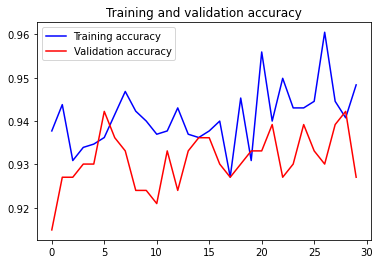

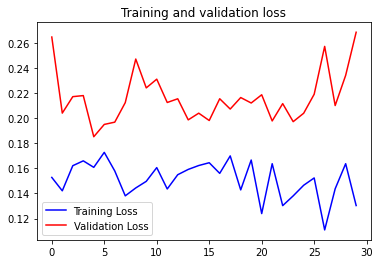

In [100]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))


plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


plt.show()

In [77]:
test_df = pd.read_csv('test.csv')
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="./images/", 
x_col="image_names", 
y_col=None,
shuffle=False,
batch_size=32,
class_mode=None,
target_size=(224,224))

Found 706 validated image filenames.


In [101]:
#model = keras.models.load_model(checkpoint_filepath)
test_generator.reset()
pred=model.predict_generator(test_generator,
verbose=1)

23/23 [==============================] - 2s 80ms/step


In [81]:
pred[1:5]

array([[1],
       [0],
       [1],
       [0]])

In [102]:
pred = np.where(pred > 0.5, 1, 0)

In [61]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


# predicted_class_indices=np.argmax(pred,axis=1)
# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# predictions = [labels[k] for k in predicted_class_indices]


# valid_generator=datagen.flow_from_dataframe(
# dataframe=traindf,
# directory="./train/",
# x_col="id",
# y_col="label",
# subset="validation",
# batch_size=32,
# seed=42,
# shuffle=True,
# class_mode="categorical",
# target_size=(32,32))

In [103]:
test_df["emergency_or_not"] = pred

In [104]:
test_df.to_csv('sample_sub.csv', index=False)

Input image shape: (1, 224, 224, 3)


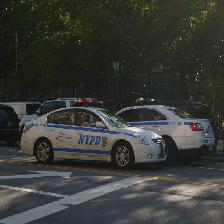

[[0.97733045]]


In [76]:
from IPython.display import Image, display
img_path = 'images/608.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)
x = x/255.0
print('Input image shape:', x.shape)
display(Image(img_path))
preds = model.predict(x)
print(preds)

In [84]:
test_df.head()

,image_names,emergency_or_not
0,1960.jpg,0
1,668.jpg,1
2,2082.jpg,0
3,808.jpg,1
4,1907.jpg,0
